In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append('..')

import metaflux
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Load data and split to training/test sites
data_dir = '../metaflux/data/conductance/Env_Gs_train_subsample.csv'
df = pd.read_csv(data_dir)

df.head()

,Unnamed: 0,Site,Lat,Lon,Datetime,PFT,Climate,Tair,SW,RH,VPD,WS,Ca,SWC,LAI,flag_rain,flag_daytime,flag_GS,flag_peak,Gs
0,631703,DE-Gri,50.9500,13.5126,2012-08-12 15:00:00,GRA,Continental,19.030,646.730,46.820,1.1711,3.380,371.520,0.27930,5.776588,0,1,1,0,0.437704
1,153541,US-SRC,31.9083,-110.8395,2008-09-28 11:00:00,OSH,Arid,30.245,834.091,33.199,2.8750,5.040,360.334,0.06243,0.514628,0,1,1,1,0.032834
2,260567,US-Goo,34.2547,-89.8735,2004-06-14 14:00:00,GRA,Temperate,30.600,796.000,63.200,1.6230,2.230,-9999.000,0.28001,4.100858,0,1,1,1,0.314082
3,931313,AU-DaS,-14.1593,131.3881,2010-06-09 10:00:00,SAV,Tropical,22.450,525.000,37.000,1.7124,3.270,350.900,0.03400,0.844350,0,1,1,0,0.145919
4,663990,CH-Fru,47.1158,8.5378,2012-06-15 09:30:00,GRA,Arctic,19.751,759.230,59.571,0.9311,1.245,360.772,0.45614,2.603535,0,1,1,1,0.647665


In [32]:
# Split and save the dataframe
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
train_df.to_csv('../metaflux/data/conductance/train/train.csv')
test_df.to_csv('../metaflux/data/conductance/test/test.csv')

## Load and modify your hyperparameters of your task

In [17]:
# Specify variables
xcolumns = ["Tair","SW","RH","VPD"]
ycolumn = "Gs"

# Load the hyperparameters for your task
config_path = '../metaflux/configs/hyperparams.yaml'
hyper_args = metaflux.configs.get_hyperparams(config_path=config_path)

hyper_args['xcolumns'] = xcolumns
hyper_args['input_size'] = len(xcolumns)
hyper_args

{'epoch': 25,
 'hidden_size': 64,
 'input_size': 4,
 'k_qry': 250,
 'k_spt': 250,
 'meta_lr': 1e-07,
 'n_way': 2,
 'num_lstm_layers': 2,
 'task_num': 1,
 'update_lr': 1e-07,
 'update_step': 250,
 'update_step_test': 5,
 'xcolumns': ['Tair', 'SW', 'RH', 'VPD']}

## Define your model

In [18]:
model_config = metaflux.configs.get_config(model="mlp", args=hyper_args) # currently supported models: ['lstm', 'bilstm', 'mlp']
learner = metaflux.learner.Learner(config=model_config, input_size=hyper_args["input_size"], hidden_size=hyper_args["hidden_size"])

learner

Learner(
  (vars): ParameterList(
      (0): Parameter containing: [torch.cuda.DoubleTensor of size 64x4 (GPU 0)]
      (1): Parameter containing: [torch.cuda.DoubleTensor of size 64 (GPU 0)]
      (2): Parameter containing: [torch.cuda.DoubleTensor of size 64x64 (GPU 0)]
      (3): Parameter containing: [torch.cuda.DoubleTensor of size 64 (GPU 0)]
      (4): Parameter containing: [torch.cuda.DoubleTensor of size 1x64 (GPU 0)]
      (5): Parameter containing: [torch.cuda.DoubleTensor of size 1 (GPU 0)]
  )
)

# Define dataloader

In [19]:
root_dir = '../metaflux/data/conductance/'

# Note that the x inputs are normalized here
fluxnet_train = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="train", batchsz=1, n_way=hyper_args["n_way"], k_shot=hyper_args["k_spt"], k_query=hyper_args["k_qry"], x_columns=hyper_args["xcolumns"], y_column=ycolumn, time_column=None)
fluxnet_test = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="test", batchsz=1, n_way=hyper_args["n_way"], k_shot=hyper_args["k_spt"], k_query=hyper_args["k_qry"], x_columns=hyper_args["xcolumns"], y_column=ycolumn, time_column=None)

 50%|█████     | 1/2 [00:00<00:00, 10.00it/s]

shuffle DB :train, b:1, 2-way, 250-shot, 250-query


 50%|█████     | 1/2 [00:00<00:00,  9.26it/s]

shuffle DB :test, b:1, 2-way, 250-shot, 250-query


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


In [20]:
support_x, support_y, query_x, query_y = next(iter(fluxnet_train))
print(support_x.shape)
print(support_y.shape)

torch.Size([2, 250, 1, 4])
torch.Size([2, 250, 1])


# Training and Evaluation

In [24]:
runs = 1

print(f"Training meta-learning models")
vals_meta_losses = []
for run in range(0,runs):
    print(f"Run: {run + 1}")
    vals_meta_loss = []

    maml = metaflux.metalearner.Meta(hyper_args, model_config)
    print(f"Model specifications: {maml}")
    
    for epoch in range(hyper_args["epoch"]):
        # fetch meta_batchsz num of episode each time
        db_train = DataLoader(fluxnet_train, hyper_args["task_num"], shuffle=True, num_workers=0)
        for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db_train):
            x_spt, y_spt, x_qry, y_qry = x_spt.to(device), y_spt.to(device), x_qry.to(device), y_qry.to(device)
            loss = maml(x_spt, y_spt, x_qry, y_qry)

            print('Epoch:', epoch, '\tTraining loss:', loss)

            if epoch % 2 == 0:  # evaluation
                db_test = DataLoader(fluxnet_test, 1, shuffle=True, num_workers=0)
                for x_spt, y_spt, x_qry, y_qry in db_test:
                    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0).to(device), y_spt.squeeze(0).to(device), x_qry.squeeze(0).to(device), y_qry.squeeze(0).to(device)
                    loss = round(maml.finetuning(x_spt, y_spt, x_qry, y_qry), 6)

                    if epoch > 0 and loss > vals_meta_loss[-1]:
                        maml.update_lr = maml.update_lr * 0.1
                        
                    vals_meta_loss.append(loss)

                print('\tValidation loss:', loss)
                
    vals_meta_losses.append(vals_meta_loss)

Training meta-learning models
Run: 1
Model specifications: Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.DoubleTensor of size 64x4 (GPU 0)]
        (1): Parameter containing: [torch.cuda.DoubleTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.DoubleTensor of size 64x64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.DoubleTensor of size 64 (GPU 0)]
        (4): Parameter containing: [torch.cuda.DoubleTensor of size 1x64 (GPU 0)]
        (5): Parameter containing: [torch.cuda.DoubleTensor of size 1 (GPU 0)]
    )
  )
)
Epoch: 0 	Training loss: 0.8721935932804288
	Validation loss: 0.190623
Epoch: 1 	Training loss: 0.8742905633618624
Epoch: 2 	Training loss: 0.8763896654561607
	Validation loss: 0.189792
Epoch: 3 	Training loss: 0.8784933484454522
Epoch: 4 	Training loss: 0.8806015037329926
	Validation loss: 0.188944
Epoch: 5 	Training loss: 0.8827261328903874
Epoch: 6 	Training loss: 0.8848430267900721
	Va

In [23]:
print("Training baseline models")
vals_base_losses = []
for run in range(0,runs):
    basemeta = metaflux.BaseMeta(hyper_args["input_size"], hyper_args["hidden_size"], arch='mlp').to(device)
    train_x, train_y = metaflux.generate_base_metadata(root=root_dir, mode="train", batchsz=1, n_way=hyper_args["n_way"], k_shot=hyper_args["k_spt"], k_query=hyper_args["k_qry"], x_columns=hyper_args["xcolumns"], y_column=ycolumn)
    test_x, test_y = metaflux.generate_base_metadata(root=root_dir, mode="test", batchsz=1, n_way=hyper_args["n_way"], k_shot=hyper_args["k_spt"], k_query=hyper_args["k_qry"], x_columns=hyper_args["xcolumns"], y_column=ycolumn)
    
    optimizer = torch.optim.Adam(basemeta.parameters(), lr=hyper_args["update_lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=0)
    criterion = torch.nn.MSELoss().to(device)
    vals_base_loss = []

    for epoch in range(hyper_args["epoch"]):
        basemeta.train()
        train_losses = []

        for i, x in enumerate(train_x):
            pred = basemeta(x.unsqueeze(0).float().to(device))
            loss = criterion(pred.view(-1,1), train_y[i].float().to(device))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        train_loss = np.array(train_losses)
        train_loss = np.mean(abs(train_loss - train_loss.mean()) / train_loss.std())
        print('Epoch:', epoch, '\tTraining loss:', train_loss)

        if epoch % 2 == 0:
            basemeta.eval()
            val_losses = []

            with torch.no_grad():
                for i, x in enumerate(test_x):
                    pred = basemeta(x.unsqueeze(0).float().to(device))
                    loss = criterion(pred.view(-1,1), test_y[i].float().to(device))
                    val_losses.append(loss.item())

            val_loss = np.array(val_losses)
            val_loss = np.mean(abs(val_loss - val_loss.mean()) / val_loss.std())
            scheduler.step(val_loss)
            vals_base_loss.append(val_loss)

            print('\tValidation loss:', val_loss)

    vals_base_losses.append(vals_base_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

Training baseline models


100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Epoch: 0 	Training loss: 0.1585214242741485
	Validation loss: 0.36213685017982505
Epoch: 1 	Training loss: 0.15716364462941945
Epoch: 2 	Training loss: 0.15593111941567872
	Validation loss: 0.3575215332826848
Epoch: 3 	Training loss: 0.15479221201763227
Epoch: 4 	Training loss: 0.15372744942503186
	Validation loss: 0.35331982086514335
Epoch: 5 	Training loss: 0.15271397962841202
Epoch: 6 	Training loss: 0.15173930617516118
	Validation loss: 0.3493639091188619
Epoch: 7 	Training loss: 0.15080997716221203
Epoch: 8 	Training loss: 0.14989729848780928
	Validation loss: 0.3455619196395266
Epoch: 9 	Training loss: 0.14899279913742391
Epoch: 10 	Training loss: 0.14810971093568595
	Validation loss: 0.34178779590909814
Epoch: 11 	Training loss: 0.1472465728234649
Epoch: 12 	Training loss: 0.14639891485667414
	Validation loss: 0.3381868789786536
Epoch: 13 	Training loss: 0.14556194070494952
Epoch: 14 	Training loss: 0.14473358361469735
	Validation loss: 0.33464052131055183
Epoch: 15 	Training lo

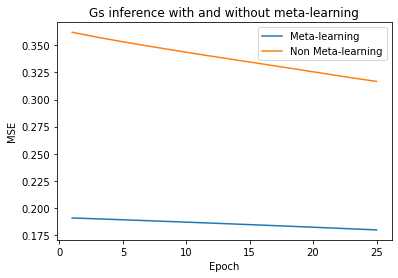

In [25]:
# Plot validation loss
f, ax = plt.subplots()
epochs = np.arange(1,hyper_args["epoch"] + 1, 2)
ax.plot(epochs, vals_meta_losses[0], label='Meta-learning')
ax.plot(epochs, vals_base_losses[0], label='Non Meta-learning')
ax.set_title("Gs inference with and without meta-learning")
ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()